In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
# DATA_PATH = '/scratch/ceph/swei20/data/ae/dataset/test'
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
SZALAY_PATH = os.path.join("/scratch/ceph/szalay/swei20/AE", 'pca.h5')
sys.path.insert(0, PROJECT_PATH)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
import tensorflow as tf
# tf.enable_v2_behavior()
gpus = tf.config.list_physical_devices('GPU') 
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### load data

In [7]:
with h5py.File(PCA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux_idx = f['flux_idx'][()]
#     Fe_H = f['Fe_H'][()]
#     log_g = f['log_g'][()]
#     O_M = f['O_M'][()]
#     C_M = f['C_M'][()]
#     T_eff = f['T_eff'][()]
    wave = f['wave'][()]
    eigv = f['flux_eigv'][()]

In [8]:
DATA_PATH = os.path.join(DATA_DIR, 'pc32.h5')
with h5py.File(DATA_PATH, 'r') as f:
#     flux = f['flux'][()]
#     flux32m = f['flux32m'][()]
    flux32ms = f['flux32ms'][()]

### Model Config

In [ ]:
config_dict ={
    "data": {
      "dir":"./data",
      "filename": "pc32.h5",
      "train": "flux32ms"
    },
    "model":{
      "aug": 1,
      "name": "eval",
      "input_dim": 32,
      "latent_dim": 8,
      "hidden_dims": [128, 64],
      "dropout": 0.0,
      "lr": 0.003,
      "reg1": 0.00001,
      "loss": "mse",
      "opt": "adam",
      "batchnorm": 0,
      "act_in": "leaky",
      "act_em": "leaky",
      "act_hd": "leaky"
    },
    "trainer":{
      "epoch": 1,
      "batch_size": 16,
      "validation_split":0.3,
      "verbose": 1,
      "save": 0
    },
    "callbacks":{
        "checkpoint_monitor": "val_loss",
        "checkpoint_mode": "min"
    }
}
config = DotMap(config_dict)

### VAE

In [17]:
from tensorflow import keras
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.activations as ka
from tensorflow.keras import Sequential as ks
from tensorflow.keras import optimizers as ko
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

In [18]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = kl.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = kl.Dense(latent_dim)(h)
z_log_sigma = kl.Dense(latent_dim)(h)

In [21]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = kl.Lambda(sampling)([z_mean, z_log_sigma])

In [26]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = kl.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [27]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [29]:
from tensorflow.keras.datasets import mnist

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [48]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        verbose=0,
        validation_data=(x_test, x_test))

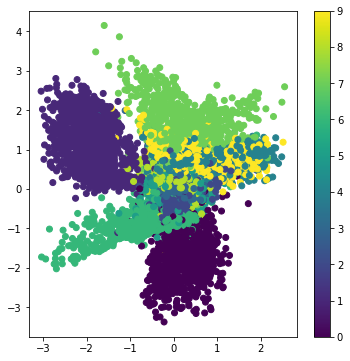

In [49]:
x_test_encoded = encoder.predict(x_test)[-1]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

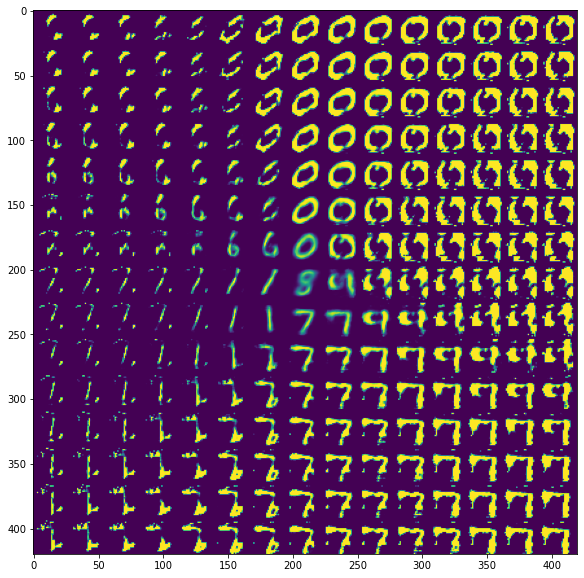

In [50]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### On pcs

In [76]:
original_dim = 32
intermediate_dim = 64
latent_dim = 5

inputs = keras.Input(shape=(original_dim,))
h = kl.Dense(intermediate_dim, activation='relu')(inputs)
h = kl.LeakyReLU()(h)
z_mean = kl.Dense(latent_dim)(h)
z_log_sigma = kl.Dense(latent_dim)(h)

In [77]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.01)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = kl.Lambda(sampling)([z_mean, z_log_sigma])

In [78]:
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = kl.Dense(intermediate_dim)(latent_inputs)
x = kl.LeakyReLU()(x)
outputs = kl.Dense(original_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [79]:
# reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = keras.losses.mse(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [80]:
x_train=flux32ms

In [81]:
x_train.shape

(116614, 32)

In [ ]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=256,
        validation_split=0.3
#         verbose=0
       )

Epoch 1/30
2551/2551 [==============================] - 6s 2ms/step - loss: 1.6163 - val_loss: 3.0046
Epoch 2/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.4862 - val_loss: 2.0505
Epoch 3/30
2551/2551 [==============================] - 7s 3ms/step - loss: 0.3665 - val_loss: 1.8625
Epoch 4/30
2551/2551 [==============================] - 6s 2ms/step - loss: 0.3175 - val_loss: 1.9086
Epoch 5/30
2543/2551 [============================>.] - ETA: 0s - loss: 0.2921

In [29]:
from tensorflow.keras.datasets import mnist

In [38]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=32,
        verbose=0,
        validation_data=(x_test, x_test))

Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 151.8447 - val_loss: 152.2706
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 151.4410 - val_loss: 151.5842
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 151.1235 - val_loss: 151.5596
Epoch 4/100
1875/1875 [==============================] - 4s 2ms/step - loss: 150.8013 - val_loss: 151.3897
Epoch 5/100
1875/1875 [==============================] - 4s 2ms/step - loss: 150.5715 - val_loss: 150.8244
Epoch 6/100
1875/1875 [==============================] - 4s 2ms/step - loss: 150.3005 - val_loss: 150.9590
Epoch 7/100
1875/1875 [==============================] - 4s 2ms/step - loss: 150.0677 - val_loss: 150.6723
Epoch 8/100
1875/1875 [==============================] - 4s 2ms/step - loss: 149.8300 - val_loss: 150.7177
Epoch 9/100
1875/1875 [==============================] - 4s 2ms/step - loss: 149.6142 - val_loss: 150.2434
Epoch 10/100
1875/1875 [=============

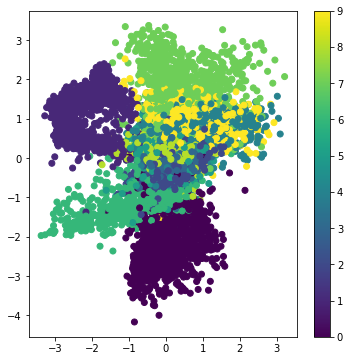

In [43]:
x_test_encoded = encoder.predict(x_test)[-1]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

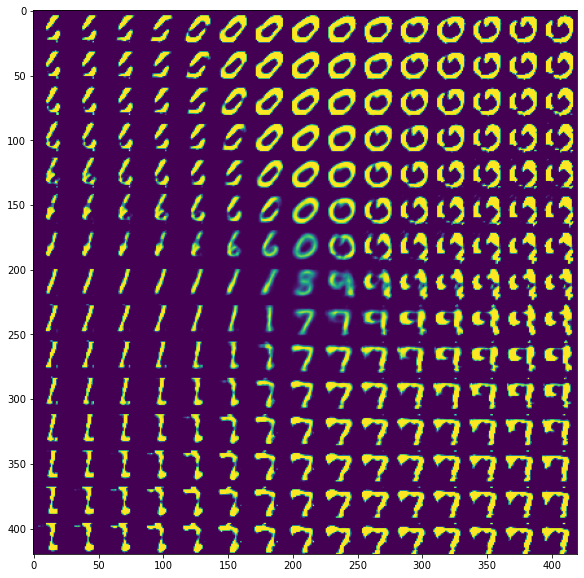

In [44]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()